In [187]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time

import pickle,h5py,json

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,Concatenate,Add,Activation,MaxPooling2D,AveragePooling2D
import keras.backend as K

from sklearn import preprocessing as pp
from sklearn.cluster import KMeans,DBSCAN,MeanShift,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import seasonal_decompose

from fuzzywuzzy import fuzz
from itertools import product

import ipywidgets as widgets

sns.set()
warnings.filterwarnings('ignore')

In [2]:
#bf = pd.read_excel('..\\..\\TF_data\\ADMIN\\01\\20191003.xlsx')
bf = pd.read_excel('..\\..\\TF_data\\ADMIN\\01\\20191003.xls')

bf['Buchungstag'] = pd.to_datetime(bf['Buchungstag'],format='%d.%m.%y')
bf['Valutadatum'] = pd.to_datetime(bf['Valutadatum'],format='%d.%m.%y')

In [102]:
df = bf[['Buchungstag','Valutadatum','Buchungstext','Verwendungszweck','Beguenstigter/Zahlungspflichtiger','Kontonummer/IBAN','Betrag']].rename(columns={
    'Valutadatum':'Date', 
    'Buchungstag':'Date_booked', 
    'Buchungstext':'Text', 
    'Verwendungszweck':'Use',
    'Beguenstigter/Zahlungspflichtiger':'CONTACT', 
    'Kontonummer/IBAN':'AccNum', 
    'Betrag':'Value'
})

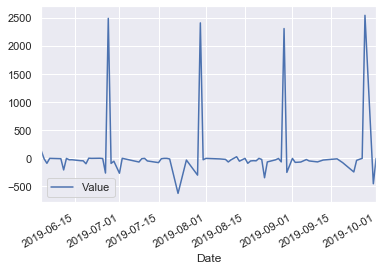

In [103]:
df[['Date','Value']].groupby(['Date']).sum().plot()

In [104]:
idx = pd.date_range(df['Date'].min(),df['Date'].max())

In [105]:
df['CONTACT'] = df['CONTACT'].fillna('Unspecified')

In [106]:
df['ORIGIN'] = df[['Text','CONTACT','AccNum']].apply(lambda x: '||'.join([str(x[k]) for k in range(len(x))]),axis=1)
df = df.drop(columns=['Text','CONTACT','AccNum'])

In [107]:
r_list = []
for p in product(df['ORIGIN'],df['ORIGIN']):
    r_list.append([p[0],p[1],fuzz.ratio(p[0],p[1])])
df0 = pd.DataFrame(r_list).rename(columns={0:'Name0',1:'Name1',2:'Ratio'})
df0 = df0.drop(index=df0[df0['Ratio']==100].index)

In [108]:
r_list = []
for k in range(df0['Name0'].unique().shape[0]):
    r_list.append(df0[df0['Name0']==df0['Name0'].unique()[k]].sort_values(by=['Ratio'],ascending=False).reset_index(drop=True).ix[0].tolist())
df1 = pd.DataFrame(r_list).rename(columns={0:'Name0',1:'Name1',2:'max_ratio'})

In [109]:
df_t = df1[df1['max_ratio']>85].drop(columns=['max_ratio']).reset_index(drop=True)

for k in range(df_t.shape[0]):
    df.ix[df[df['ORIGIN']==df_t.ix[k].Name0].index,'ORIGIN'] = df_t.ix[k].Name1

In [110]:
cat_dict = df['ORIGIN'].astype('category').cat
df['ORIGIN'] = cat_dict.codes

In [111]:
df2 = df[['Date','Value']].groupby(['Date']).sum().reindex(idx,fill_value=0)

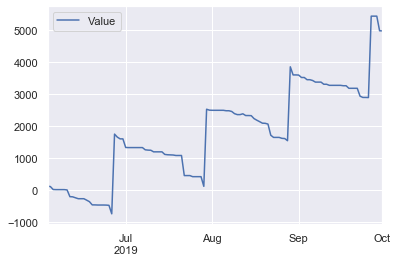

In [112]:
df2.cumsum().plot()

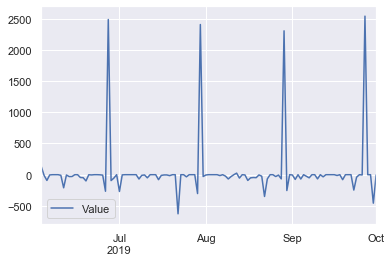

In [113]:
df2.plot()

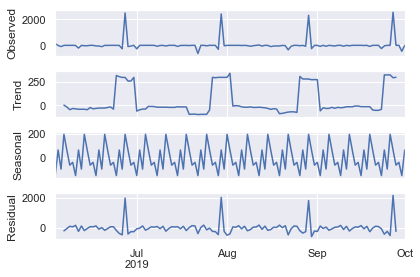

In [114]:
seasonal_decompose(df2).plot()
plt.show()

In [115]:
df3 = df[['Date','ORIGIN','Value']]
df3['Count'] = 1

df3_0 = df3[['ORIGIN','Count','Value']].groupby(['ORIGIN']).sum().sort_values(by='Count',ascending=False).reset_index().rename(columns={'Value':'Value_t'})

In [116]:
df3 = df[['Date','ORIGIN','Value']]
df3_1 = df3[['ORIGIN','Value']].groupby(['ORIGIN']).mean().reset_index().rename(columns={'Value':'Value_m'})

In [117]:
df3 = pd.merge(df3_0,df3_1)

In [118]:
df3 = df3.drop(df3[df3['Value_t']==0].index).reset_index(drop=True)

In [119]:
df4 = df[['Date','Value','ORIGIN']].copy()
df4 = df4.groupby(['ORIGIN','Date']).sum().reset_index()

In [120]:
df3['Freq[M]'] = np.nan
for contact_name in df4['ORIGIN'].unique().tolist():
    n_months = (df4[df4['ORIGIN']==contact_name]['Date'].max()-df4[df4['ORIGIN']==contact_name]['Date'].min())/np.timedelta64(1,'M')
    n_contacts = df4[df4['ORIGIN']==contact_name].shape[0]
    if n_months>0: df3.ix[df3[df3['ORIGIN']==contact_name].index,'Freq[M]'] = n_contacts/n_months

In [121]:
df3 = df3.drop(index=df3[df3['Count']<=1].index).reset_index(drop=True)

In [122]:
df3['Scaled Mean Value'] = np.sign(df3['Value_m'])*np.log(df3['Value_m'].abs())
df3['Scaled Total Value'] = np.sign(df3['Value_t'])*np.log(df3['Value_t'].abs())

In [123]:
gmm = GaussianMixture(n_components=6)
df3['GMM Class'] = gmm.fit_predict(df3[['Count','Value_t','Value_m','Freq[M]','Scaled Mean Value','Scaled Total Value']].values)+1

In [124]:
tsne = TSNE()
tsne_comp = tsne.fit_transform(df3[['Count','Value_t','Value_m','Freq[M]','Scaled Mean Value','Scaled Total Value']].values)

df3['TSNE0'] = tsne_comp[:,0]
df3['TSNE1'] = tsne_comp[:,1]

In [125]:
pca = PCA()
pca_comp = pca.fit_transform(df3[['Count','Value_t','Value_m','Freq[M]','Scaled Mean Value','Scaled Total Value']].values)

df3['PCA0'] = pca_comp[:,0]
df3['PCA1'] = pca_comp[:,1]

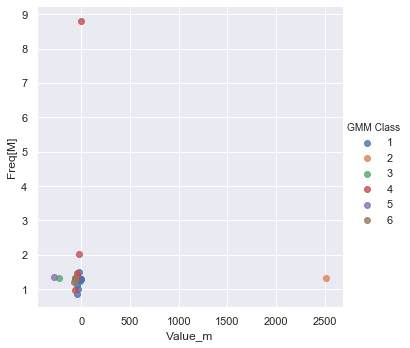

In [174]:
sns.lmplot(x='Value_m',y='Freq[M]',data=df3,hue='GMM Class',fit_reg=False)

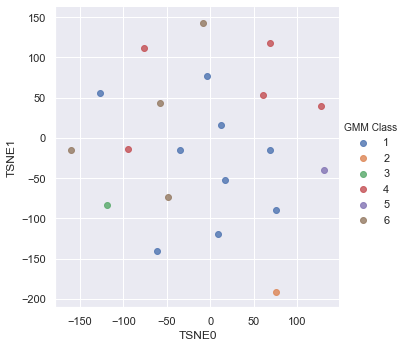

In [126]:
sns.lmplot(x='TSNE0',y='TSNE1',data=df3,hue='GMM Class',fit_reg=False)

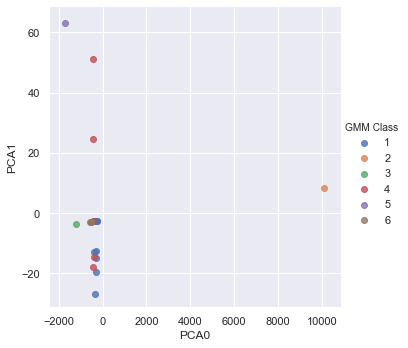

In [127]:
sns.lmplot(x='PCA0',y='PCA1',data=df3,hue='GMM Class',fit_reg=False)

In [128]:
df = df[df['ORIGIN'].apply(lambda x: x in df3['ORIGIN'].unique().tolist())]

In [129]:
df['GMM Class'] = df['ORIGIN'].apply(lambda x: df3[df3['ORIGIN']==x]['GMM Class'].tolist()[0])

In [169]:
df['ORIGIN PLAIN'] = df['ORIGIN'].apply(lambda x: cat_dict.categories[x])

In [193]:
'\n'.join(df[df['GMM Class']==1]['ORIGIN PLAIN'].unique().tolist())

'ENTGELTABSCHLUSS||Unspecified||0\nFOLGELASTSCHRIFT||SLF Sportland Franken GmbH & Co. KG||DE88763500000000062725\nFOLGELASTSCHRIFT||IGM Erlangen||DE28500500000083044008\nFOLGELASTSCHRIFT||M-net Telekommunikations GmbH||DE74700500000000028273\nBARGELDAUSZAHLUNG||F-GINNHEIM//FRANKFURTER SPARKASSE/DE||DE12500502019000481418\nBARGELDAUSZAHLUNG||LUITPOLDST//SPARKASSE ERLANGEN/DE||DE63763500009000481424\nKARTENZAHLUNG||ALDI GMBH + CO. KG//ERLANGEN/DE||DE29300500000001132513\nBARGELDAUSZAHLUNG||STINTZINGS//SPARKASSE ERLANGEN/DE||DE63763500009000481424\nBARGELDAUSZAHLUNG||ARCADEN//SPARKASSE ERLANGEN/DE||DE68763500009000481431'

Textarea(value='ENTGELTABSCHLUSS||Unspecified||0\nFOLGELASTSCHRIFT||SLF Sportland Franken GmbH & Co. KG||DE887…

In [236]:
@ widgets.interact(Class=[1,2,3,4,5,6])
def plot(Class):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.plot(df[df['GMM Class']==Class][['Date','Value']].groupby('Date').sum().reindex(idx,fill_value=0))
    ax2.plot(df[df['GMM Class']==Class][['Date','Value']].groupby('Date').sum().reindex(idx,fill_value=0).cumsum())
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
    plt.show()
    w = widgets.Textarea(
        value='\n'.join(df[df['GMM Class']==Class]['ORIGIN PLAIN'].unique().tolist()),
        placeholder='Empty',
        description='Accounts for:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='200px')
    )
    display(w)

interactive(children=(Dropdown(description='Class', options=(1, 2, 3, 4, 5, 6), value=1), Output()), _dom_clas…

In [290]:
@ widgets.interact(Class = widgets.SelectMultiple(
    options=[1,2,3,4,5,6],
    value=[1,2,3,4,5,6],
    rows=7,
    description='Exp Classes',
    disabled=False,
    layout=widgets.Layout(width='50%')
))
def plot_restricted(Class):
    fig = plt.figure(figsize=(15,7))
    plt.plot(df[df['GMM Class'].apply(lambda x: x in list(Class))][['Date','Value']].groupby('Date').sum().reindex(idx,fill_value=0).cumsum())
    plt.xticks(rotation=45)
    plt.show()

interactive(children=(SelectMultiple(description='Exp Classes', index=(0, 1, 2, 3, 4, 5), layout=Layout(width=…

In [303]:
df[(df['Date']>=pd.datetime(2019,6,1))&(df['Date']<pd.datetime(2019,7,1))][['GMM Class','Value']].groupby('GMM Class').sum()

,Value
GMM Class,
1,-159.03
2,2485.77
4,-408.59
5,-204.09
6,-206.82


In [300]:
df['Date'].min()

Timestamp('2019-06-03 00:00:00')